<a href="https://colab.research.google.com/github/Jathurshan0330/BRATS-Brain-Tumor-Segmentation/blob/master/170248G_BM4301_Brain_Tumor_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Get Requirements

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install itk itkwidgets ipywidgets
clear_output()

In [ ]:
#Import Libraries
import itk
import numpy as np
import nibabel as nib
import itk
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
import torch.nn as nn
sns.set_style('darkgrid')

#Load Data

In [ ]:
def rescale_img(img, is_np = False):
  img = itk.array_from_image(img)
  print(np.min(img),np.max(img))
  img = (img/np.max(img))*255
  if is_np:
    return img
  img = itk.image_from_array(img)
  print(np.min(img),np.max(img))
  return img

In [ ]:
base = '/content/drive/MyDrive/brats2018/Brats18_2013_10_1_'

flair_fn = base + 'flair.nii'
t1_fn = base + 't1.nii'
t1ce_fn = base + 't1ce.nii'
t2_fn = base + 't2.nii'
seg_fn = base + 'seg.nii'

flair = rescale_img(itk.imread(flair_fn))
t1 = rescale_img(itk.imread(t1_fn))
t1ce = rescale_img(itk.imread(t1ce_fn))
t2 = rescale_img(itk.imread(t2_fn))
seg = itk.imread(seg_fn)
print(flair.shape, t1.shape, t1ce.shape, t2.shape, seg.shape)


flair = flair.astype(itk.F)
t1 = t1.astype(itk.F)
t1ce = t1ce.astype(itk.F)
t2 = t2.astype(itk.F)


## Visulaization

(<matplotlib.image.AxesImage at 0x7f64ccb458d0>, Text(0.5, 1.0, 'seg'))

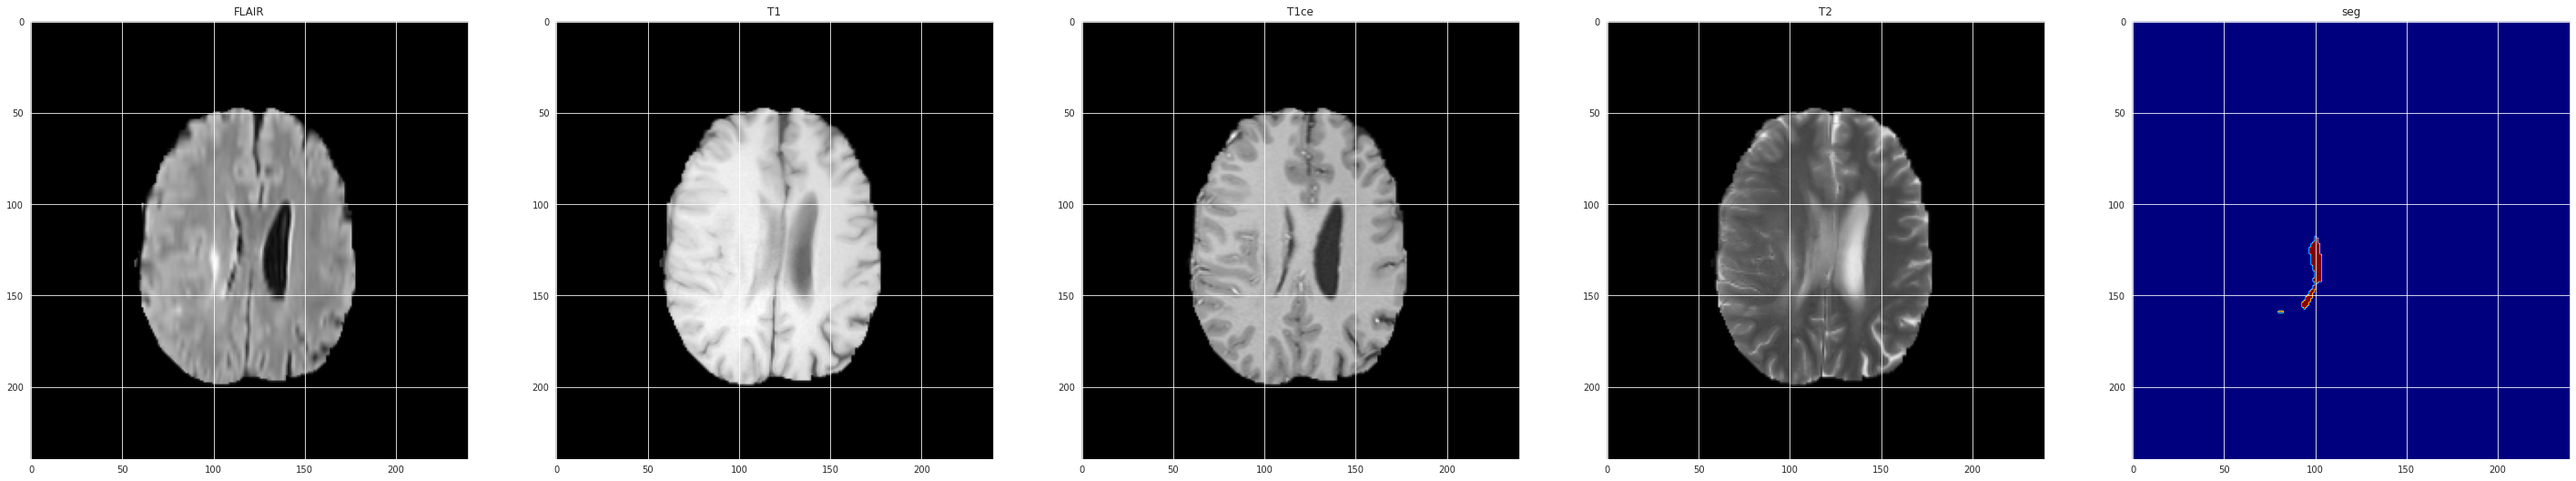

In [ ]:
#Visualize images
slice = 100
fig, ax = plt.subplots(1,5, figsize=(50,10))
ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('FLAIR')
ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1')
ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce')
ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2')
ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('seg')

In [ ]:
#Interactive visualization
# Create layer slider
select_slice = IntSlider(min=0, max=flair.shape[0]-1, description='Select Slice', continuous_update=False)

# Define a function for plotting images
def plot_image(slice):
    print(f"Plotting {slice} Slice")
    fig, ax = plt.subplots(1,5, figsize=(50,10))
    ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('FLAIR')
    ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1')
    ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce')
    ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2')
    ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('seg')


# Use the interactive() tool to create the visualization
interactive(plot_image, slice=select_slice)
    

interactive(children=(IntSlider(value=0, continuous_update=False, description='Select Slice', max=154), Output…

In [ ]:
from seaborn.matrix import clustermap
def interactive_plot(flair_1,t1_1,t1ce_1,t2_1,seg_1, cmap = 'jet', seed = None):
  def plot_image(slice):
    print(f"Plotting {slice} Slice")
    fig, ax = plt.subplots(1,5, figsize=(50,10))
    ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('FLAIR',fontsize = 50)
    ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 50)
    ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 50)
    ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 50)
    ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('seg',fontsize = 50)
    if seed:
      ax[0].scatter(seed[0], seed[1], color = 'r')
      ax[1].scatter(seed[0], seed[1], color = 'r')
      ax[2].scatter(seed[0], seed[1], color = 'r')
      ax[3].scatter(seed[0], seed[1], color = 'r')
    plt.show()

    fig, ax = plt.subplots(1,5, figsize=(50,10))
    ax[0].imshow(flair_1[slice], cmap=cmap), ax[0].set_title('FLAIR',fontsize = 50)
    ax[1].imshow(t1_1[slice], cmap=cmap), ax[1].set_title('T1',fontsize = 50)
    ax[2].imshow(t1ce_1[slice], cmap=cmap), ax[2].set_title('T1ce',fontsize = 50)
    ax[3].imshow(t2_1[slice], cmap=cmap), ax[3].set_title('T2',fontsize = 50)
    ax[4].imshow(seg_1[slice], cmap='jet'), ax[4].set_title('seg',fontsize = 50)
    plt.show()
  select_slice = IntSlider(min=0, max=flair.shape[0]-1, description='Select Slice', continuous_update=False)
  return interactive(plot_image, slice=select_slice)

interactive_plot(flair,t1,t1ce,t2,seg, cmap = 'gray')

interactive(children=(IntSlider(value=0, continuous_update=False, description='Select Slice', max=154), Output…

# Segmentation using 5 algorithms in ITK

Segmentation algorithms are built with the aid of ITK documentation :
https://itk.org/ITKExamples

In [ ]:
def plotting_images(flair_1, t1_1,t1ce_1,t2_1, seg_1, cmap = 'jet'):
  fig, ax = plt.subplots(1,5, figsize=(50,10))
  ax[0].imshow(flair_1, cmap=cmap), ax[0].set_title('FLAIR')
  ax[1].imshow(t1_1, cmap=cmap), ax[1].set_title('T1')
  ax[2].imshow(t1ce_1, cmap=cmap), ax[2].set_title('T1ce')
  ax[3].imshow(t2_1, cmap=cmap), ax[3].set_title('T2')
  ax[4].imshow(seg_1, cmap='jet'), ax[4].set_title('seg')
  plt.show()


## Watershed Image Filter

Segmentation of the tumor using the watershed method

In [ ]:
"""
WatershedImageFilter function in ITK is used.

threshold : absolute minimum height value used during processing.
            Raising this threshold percentage effectively decreases the number of local minima in the input,
            resulting in an initial segmentation with fewer regions.

evel: parameter controls the depth of metaphorical flooding of the image.
       That is, it sets the maximum saliency value of interest in the result.
       Raising and lowering the Level influences the number of segments
       in the basic segmentation that are merged to produce the final output.
       A level of 1.0 is analogous to flooding the image up to a
       depth that is 100 percent of the maximum value in the image.
       A level of 0.0 produces the basic segmentation, which will typically be very oversegmented.
       Level values of interest are typically low (i.e. less than about 0.40 or 40%),
       since higher values quickly start to undersegment the image.
"""

def water_shed_segmentation(mri_img, thresh, level):
  mri_grad_mag_filt = itk.GradientMagnitudeImageFilter(mri_img)
  mri_watershed = itk.WatershedImageFilter(mri_grad_mag_filt,threshold = thresh, level = level)
  return mri_watershed,mri_grad_mag_filt

#### 2D Segmentation

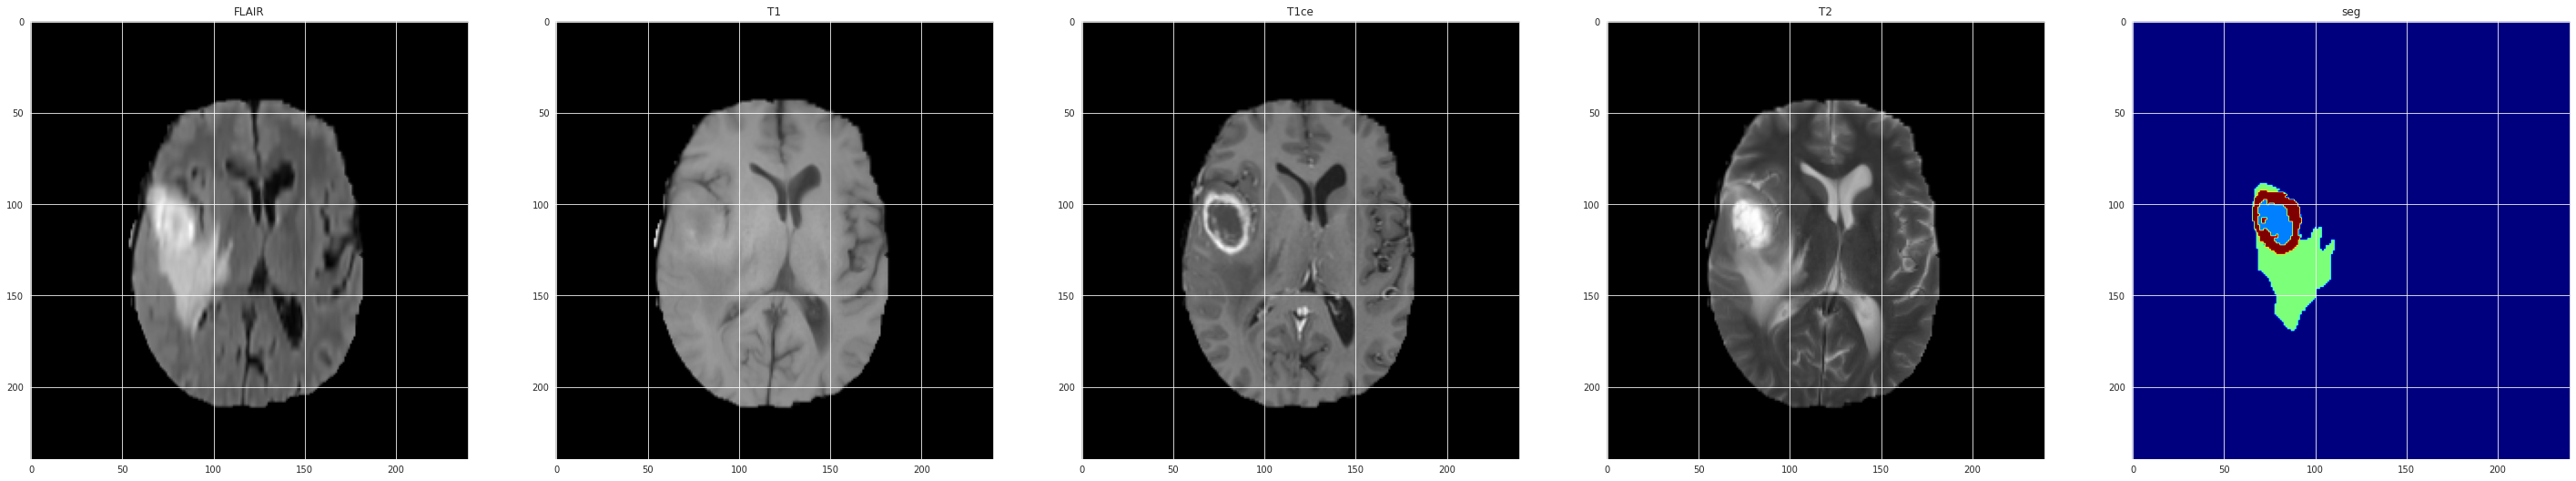

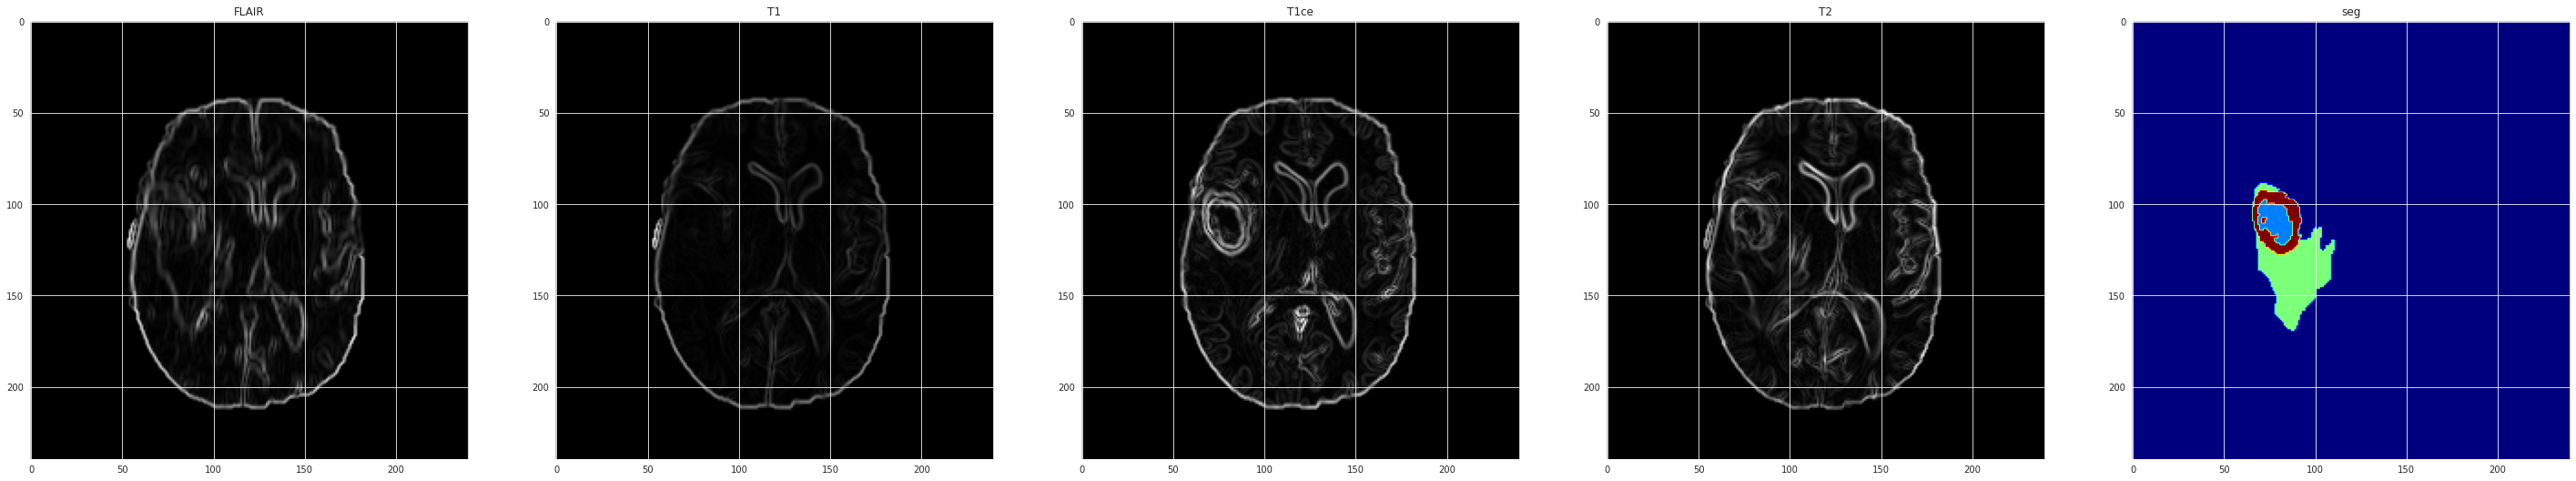

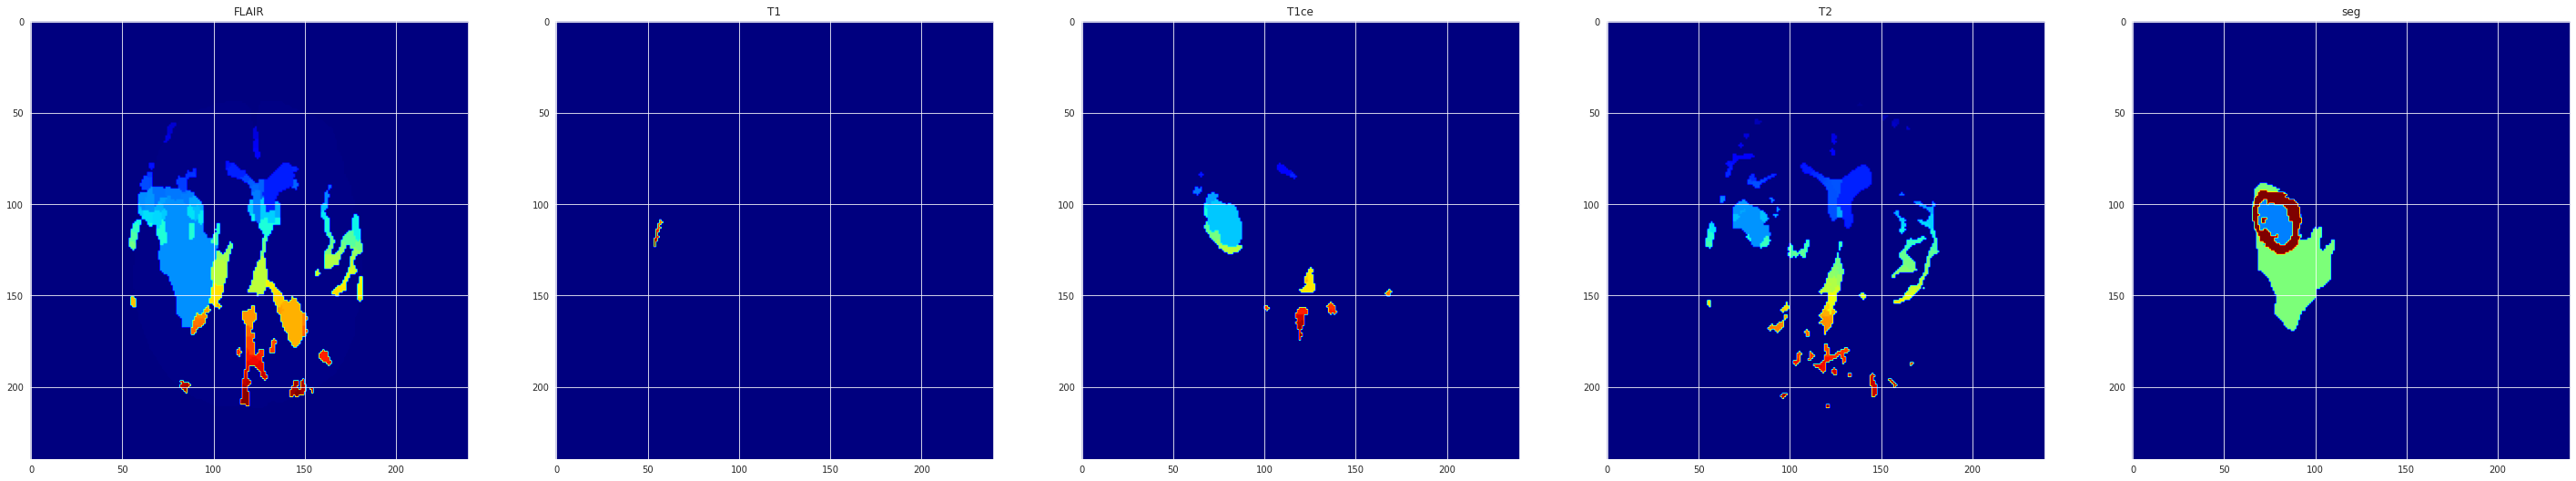

In [ ]:
slice_no = 79

flair_slice = itk.image_from_array(flair[slice_no,:,:])
t1_slice = itk.image_from_array(t1[slice_no,:,:])
t1ce_slice = itk.image_from_array(t1ce[slice_no,:,:])
t2_slice = itk.image_from_array(t2[slice_no,:,:])
seg_slice = itk.image_from_array(seg[slice_no,:,:])

flair_watershed, flair_grad_mag_filt =  water_shed_segmentation(flair_slice, thresh = 0.06, level = 0.1 )
t1_watershed, t1_grad_mag_filt =  water_shed_segmentation(t1_slice, thresh = 0.26, level = 0.3)
t1ce_watershed, t1ce_grad_mag_filt =  water_shed_segmentation(t1ce_slice, thresh = 0.16, level = 0.35)
t2_watershed, t2_grad_mag_filt =  water_shed_segmentation(t2_slice, thresh = 0.1, level = 0.2 )

plotting_images(flair_slice, t1_slice, t1ce_slice, t2_slice, seg_slice, cmap = 'gray')
plotting_images(flair_grad_mag_filt, t1_grad_mag_filt, t1ce_grad_mag_filt, t2_grad_mag_filt, seg_slice, cmap = 'gray')
plotting_images(flair_watershed, t1_watershed, t1ce_watershed, t2_watershed, seg_slice, cmap = 'jet')

  
  

#### 3D Segmentation

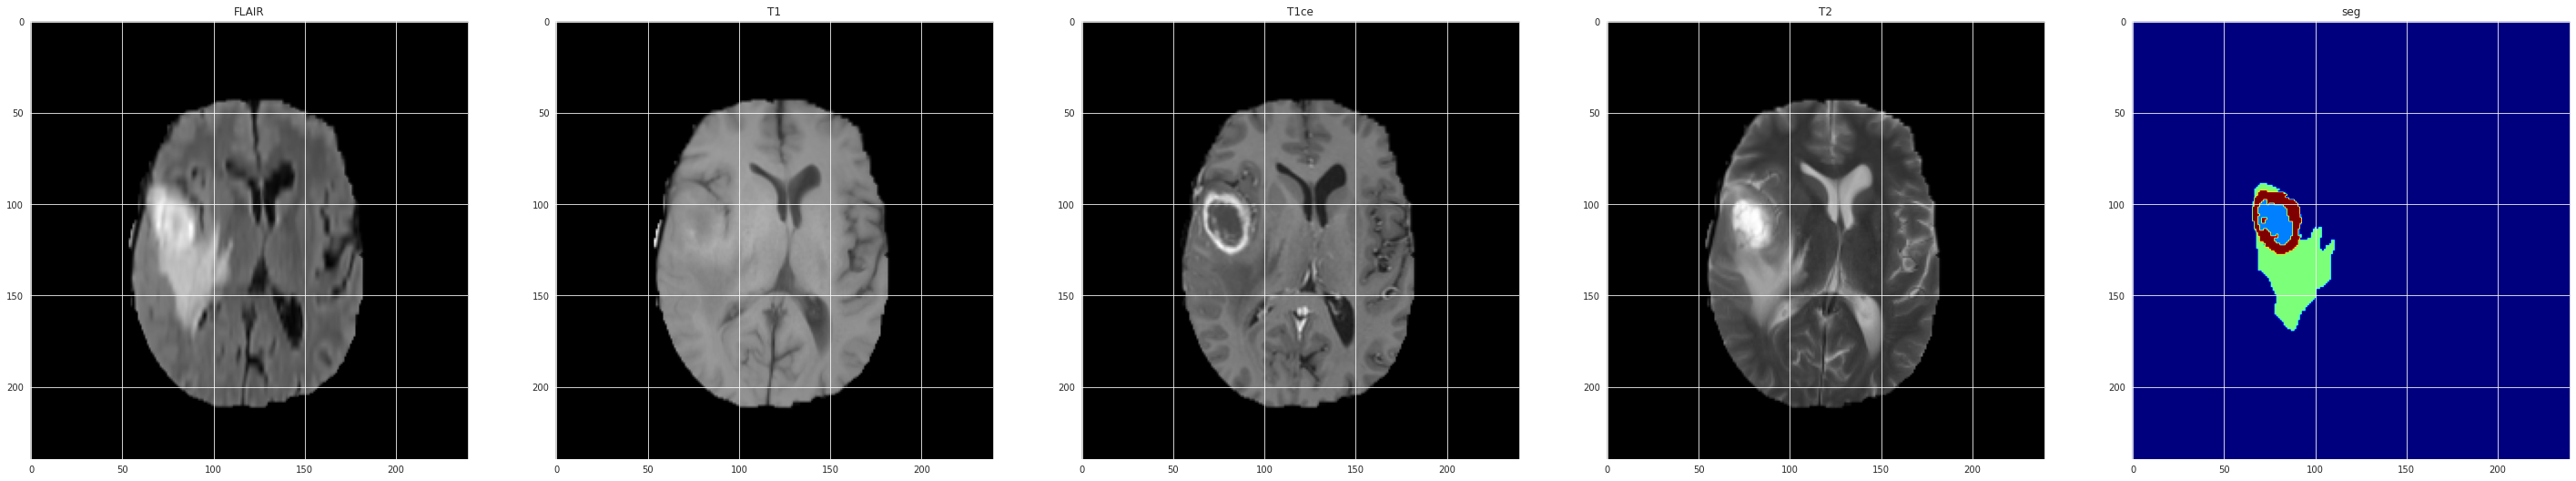

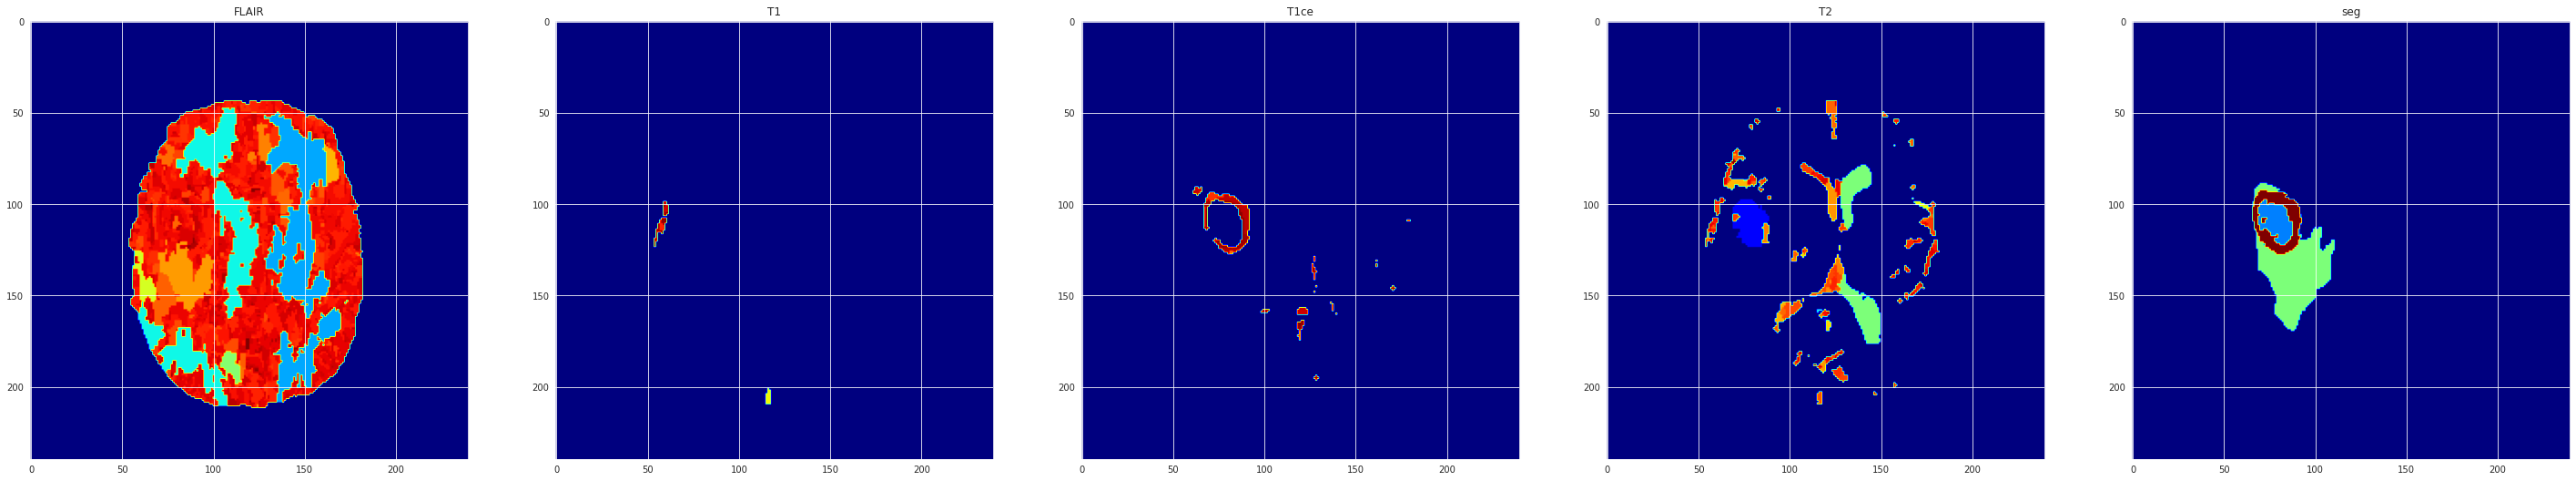

In [ ]:
flair_watershed_3D, _ =  water_shed_segmentation(flair, thresh = 0.012, level = 0.000001 )
t1_watershed_3D, _ =  water_shed_segmentation(t1, thresh = 0.026, level = 0.3 )
t1ce_watershed_3D, _ =  water_shed_segmentation(t1ce, thresh = 0.0009, level = 0.3 )
t2_watershed_3D, _ =  water_shed_segmentation(t2, thresh = 0.004, level = 0.2 )

plotting_images(flair[slice_no,:,:], t1[slice_no,:,:], t1ce[slice_no,:,:], t2[slice_no,:,:], seg[slice_no,:,:], cmap = 'gray')
plotting_images(flair_watershed_3D[slice_no,:,:], t1_watershed_3D[slice_no,:,:], t1ce_watershed_3D[slice_no,:,:], t2_watershed_3D[slice_no,:,:], seg[slice_no,:,:], cmap = 'jet')

In [ ]:
interactive_plot(flair_watershed_3D,t1_watershed_3D,t1ce_watershed_3D,t2_watershed_3D,seg, cmap = 'jet')

## Canny-Edge Level Set Segmentation

In [ ]:
def canny_segmentation(mri_img, AdvectionScaling = 10, CurvatureScaling = 0, 
                      PropagationScaling = 0, Variance =0.1, Threshold = 7, NumberOfIterations = 15,
                      MaximumRMSError = 0.01, IsoSurfaceValue = 127.5):
  mri_ani = itk.GradientAnisotropicDiffusionImageFilter(mri_img, NumberOfIterations = 5,TimeStep = 0.125,ConductanceParameter = 1 )
  mri_canny = itk.CannySegmentationLevelSetImageFilter(mri_img,FeatureImage = mri_ani, AdvectionScaling = AdvectionScaling, CurvatureScaling = 0, 
                                                       PropagationScaling = 0, Variance =0.1, Threshold = 7, NumberOfIterations = 15,
                                                       MaximumRMSError = 0.01, IsoSurfaceValue = 127.5 )
  return mri_canny,mri_ani

In [ ]:
#CannySegmentationLevelSetImageFilter

# flair_ani = itk.GradientAnisotropicDiffusionImageFilter(flair, NumberOfIterations = 5,TimeStep = 0.125,ConductanceParameter = 1 )
# t1_ani = itk.GradientAnisotropicDiffusionImageFilter(t1, NumberOfIterations = 5,TimeStep = 0.125,ConductanceParameter = 1 )
# t1ce_ani = itk.GradientAnisotropicDiffusionImageFilter(t1ce, NumberOfIterations = 5,TimeStep = 0.125,ConductanceParameter = 1 )
# t2_ani = itk.GradientAnisotropicDiffusionImageFilter(t2, NumberOfIterations = 5,TimeStep = 0.125,ConductanceParameter = 1 )

flair_canny = itk.CannySegmentationLevelSetImageFilter(flair,FeatureImage = flair_ani, AdvectionScaling = 10, CurvatureScaling = 0, 
                                                       PropagationScaling = 0, Variance =0.1, Threshold = 7, NumberOfIterations = 15,
                                                       MaximumRMSError = 0.01, IsoSurfaceValue = 127.5 )
t1_canny = itk.CannySegmentationLevelSetImageFilter(t1,FeatureImage = t1_ani, AdvectionScaling = 10, CurvatureScaling = 0, 
                                                       PropagationScaling = 0, Variance =0.1, Threshold = 7, NumberOfIterations = 15,
                                                       MaximumRMSError = 0.01, IsoSurfaceValue = 127.5 )
t1ce_canny = itk.CannySegmentationLevelSetImageFilter(t1ce,FeatureImage = t1ce_ani, AdvectionScaling = 10, CurvatureScaling = 0, 
                                                       PropagationScaling = 0, Variance =0.3, Threshold = 7, NumberOfIterations = 15,
                                                       MaximumRMSError = 0.01, IsoSurfaceValue = 127.5 )

t2_canny = itk.CannySegmentationLevelSetImageFilter(t2,FeatureImage = t2_ani, AdvectionScaling = 10, CurvatureScaling = 0, 
                                                       PropagationScaling = 0, Variance =0.1, Threshold = 7, NumberOfIterations = 15,
                                                       MaximumRMSError = 0.01, IsoSurfaceValue = 127.5 )

In [ ]:
interactive_plot(flair_canny,t1_canny,t1ce_canny,t2_canny,seg, cmap = 'jet')

## Neighborhood Connected

In [ ]:
#NeighborhoodConnectedImageFilter


#CurvatureFlowImageFilter is used here to smooth the image while preserving edges.
flair_smooth = itk.curvature_flow_image_filter(flair, number_of_iterations = 5, time_step = 0.125)
t1_smooth = itk.curvature_flow_image_filter(t1, number_of_iterations = 5, time_step = 0.125)
t1ce_smooth = itk.curvature_flow_image_filter(t1ce, number_of_iterations = 5, time_step = 0.125)
t2_smooth = itk.curvature_flow_image_filter(t2, number_of_iterations = 5, time_step = 0.125)


flair_nc = itk.NeighborhoodConnectedImageFilter(flair_smooth,Radius = 2, Lower = 120, Upper = 125, Seed = (79,80,110), ReplaceValue = 255 )
t1_nc = itk.NeighborhoodConnectedImageFilter(t1_smooth,Radius = 2, Lower = 120, Upper = 125, Seed = (79,80,110), ReplaceValue = 255 )
t1ce_nc = itk.NeighborhoodConnectedImageFilter(t1ce_smooth, Lower = 180, Upper = 200, Seed = (79,80,110), ReplaceValue = 255 )
t2_nc = itk.NeighborhoodConnectedImageFilter(t2_smooth,Radius = 2, Lower = 120, Upper = 125, Seed = (79,80,110), ReplaceValue = 255 )

In [ ]:
interactive_plot(flair_nc,t1_nc,t1ce_nc,t2_nc,seg, cmap = 'jet',seed=(80,110))

## Fast Marching Segmentation

In [ ]:
# from numpy.lib.function_base import kaiser
# #FastMarchingImageFilter
# t1ce_ani = itk.CurvatureAnisotropicDiffusionImageFilter(t1ce,TimeStep = 0.125,NumberOfIterations =5, ConductanceParameter = 9  )
# t1ce_gm = itk.GradientMagnitudeRecursiveGaussianImageFilter(t1ce_ani,Sigma =1)
# t1ce_sig = itk.SigmoidImageFilter(t1ce_gm,OutputMinimum = 0, OutputMaximum = 1,Alpha = -0.5, Beta = 3)
# # t1ce_fm = itk.FastMarchingImageFilter(t1ce_sig,StoppingValue = 500 , Seed = (79,80,110))


# InternalPixelType = itk.F
# Dimension = 3
# InternalImageType = itk.Image[InternalPixelType, Dimension]
# OutputPixelType = itk.UC
# OutputImageType = itk.Image[OutputPixelType, Dimension]
# fastMarching = itk.FastMarchingImageFilter[InternalImageType, InternalImageType].New()
# fastMarching.SetInput(t1ce_sig)
# seed = (79,80,110)
# seed_position = [(seed[0], seed[1],seed[2])]
# seed_value = 0

# NodeType = itk.LevelSetNode[InternalPixelType, Dimension]
# seed_container = itk.VectorContainer[itk.UI, NodeType].New()
# seed_container.Initialize()

# for i,p in enumerate(seed_position):
#     node = NodeType()
#     node.SetIndex(p)
#     node.SetValue(0.0)
#     seed_container.InsertElement(i, node)
# fastMarching.SetTrialPoints(seed_container)
# fastMarching.SetOutputSize(t1ce.GetBufferedRegion().GetSize())
# stoppingTime = 500
# fastMarching.SetStoppingValue(stoppingTime)

# t1ce_fm = fastMarching.GetOutput()

# t1ce_bin = itk.BinaryThresholdImageFilter(t1ce_fm,LowerThreshold = 0 ,UpperThreshold = 50, OutsideValue = 0, InsideValue = 255)

In [ ]:
def Fast_March(img, seed, sigma, alpha, beta, time_threshold):
  InternalPixelType = itk.F
  Dimension = 3
  InternalImageType = itk.Image[InternalPixelType, Dimension]
  OutputPixelType = itk.UC
  OutputImageType = itk.Image[OutputPixelType, Dimension]

  thresholder = itk.BinaryThresholdImageFilter[InternalImageType, OutputImageType].New() 
  thresholder.SetLowerThreshold(0.0)
  thresholder.SetUpperThreshold(time_threshold)
  thresholder.SetOutsideValue(0)
  thresholder.SetInsideValue(255)

  # reader = itk.ImageFileReader[InternalImageType].New()
  # writer = itk.ImageFileWriter[OutputImageType].New()

  # reader.SetFileName('Images/BrainProtonDensitySlice9.png')
  # writer.SetFileName('Images/fast_marching_output.png')

  caster1 = itk.RescaleIntensityImageFilter[InternalImageType, OutputImageType].New()
  smoothing = itk.CurvatureAnisotropicDiffusionImageFilter[InternalImageType, InternalImageType].New()

  gradientMagnitude = itk.GradientMagnitudeRecursiveGaussianImageFilter[InternalImageType, InternalImageType].New()

  sigmoid = itk.SigmoidImageFilter[InternalImageType, InternalImageType].New()
  sigmoid.SetOutputMinimum(0.0)
  sigmoid.SetOutputMaximum(1.0)

  fastMarching = itk.FastMarchingImageFilter[InternalImageType, InternalImageType].New()

  smoothing.SetInput(img)
  gradientMagnitude.SetInput(smoothing.GetOutput())
  sigmoid.SetInput(gradientMagnitude.GetOutput())
  fastMarching.SetInput(sigmoid.GetOutput())
  thresholder.SetInput(fastMarching.GetOutput())

  smoothing.SetTimeStep(0.125)
  smoothing.SetNumberOfIterations(5)
  smoothing.SetConductanceParameter(9.0)
  
  gradientMagnitude.SetSigma(sigma)

  sigmoid.SetAlpha(alpha)
  sigmoid.SetBeta(beta)

  seed_position = [(seed[0], seed[1],seed[2])]
  seed_value = 0

  NodeType = itk.LevelSetNode[InternalPixelType, Dimension]
  seed_container = itk.VectorContainer[itk.UI, NodeType].New()
  seed_container.Initialize()

  for i,p in enumerate(seed_position):
      node = NodeType()
      node.SetIndex(p)
      node.SetValue(0.0)
      seed_container.InsertElement(i, node)
  fastMarching.SetTrialPoints(seed_container)

  fastMarching.SetOutputSize(sigmoid.GetOutput().GetBufferedRegion().GetSize())
  stoppingTime = 500
  fastMarching.SetStoppingValue(stoppingTime)


  gm_img = gradientMagnitude.GetOutput()  
  sig_img = sigmoid.GetOutput() 
  fm_img = fastMarching.GetOutput()
  thresh_img = thresholder.GetOutput() 

  fig, ax = plt.subplots(1, 5, figsize=(20,10))
  ax[0].imshow(img[79,:,:], cmap='gray', vmin=0, vmax=255)
  ax[0].scatter(seed[1], seed[2], color='r')
  ax[0].set_title('Input')
  ax[1].imshow(gm_img[79,:,:], cmap='gray')
  ax[1].set_title('Grad Mag')
  ax[2].imshow(sig_img[79,:,:], cmap='gray')
  ax[2].set_title('Sigmoid')
  ax[3].imshow(fm_img[79,:,:])
  ax[3].set_title('FM')
  ax[4].imshow(thresholder.GetOutput()[79,:,:], cmap='gray')
  ax[4].set_title('Thresholded')

  
  return gm_img, sig_img, fm_img, thresh_img

In [ ]:
seed = [0,0,0]
seed[0], seed[1],seed[2],  sigma, alpha, beta, time_threshold =  [79, 80, 110, 1.0, -0.5, 3.0, 250]

flair_gm, flair_sig, flair_fm, flair_thresh =  Fast_March(flair, seed, sigma, alpha, beta, time_threshold)
t1_gm, t1_sig, t1_fm, t1_thresh =  Fast_March(t1, seed, sigma, alpha, beta, time_threshold)
t1ce_gm, t1ce_sig, t1ce_fm, t1ce_thresh =  Fast_March(t1ce, seed, sigma, alpha, beta, time_threshold)
t2_gm, t2_sig, t2_fm, t2_thresh =  Fast_March(t2, seed, sigma, alpha, beta, time_threshold)

In [ ]:
interactive_plot(flair_fm,t1_fm,t1ce_fm,t2_fm,seg, cmap = 'jet')

In [ ]:
interactive_plot(flair_thresh,t1_thresh,t1ce_thresh,t2_thresh,seg, cmap = 'jet')

## Isolated Connected

In [ ]:
## IsolatedConnectedImageFilter

flair_ic = itk.IsolatedConnectedImageFilter(flair, Lower = 5, Seed1 =75, Seed2 = 80)#100)
t1_ic = itk.IsolatedConnectedImageFilter(t1, Lower = 60,  Seed1 = 75, Seed2 =80)#100)
t1ce_ic = itk.IsolatedConnectedImageFilter(t1ce, Lower = 55, Seed1 = 75, Seed2 = 80)#100)
t2_ic = itk.IsolatedConnectedImageFilter(t2, Lower = 110, Seed1 = 75, Seed2 = 80)#100)


slice_no = 79
fig, ax = plt.subplots(1,5, figsize=(50,10))
ax[0].imshow(flair_ic[slice_no,:,:], cmap='gray'), ax[0].set_title('FLAIR')
ax[1].imshow(t1_ic[slice_no], cmap='gray'), ax[1].set_title('T1')
ax[2].imshow(t1ce_ic[slice_no], cmap='gray'), ax[2].set_title('T1ce')
ax[3].imshow(t2_ic[slice_no], cmap='gray'), ax[3].set_title('T2')
ax[4].imshow(seg[slice_no], cmap='jet'), ax[4].set_title('seg')


In [ ]:
interactive_plot(flair_ic,t1_ic,t1ce_ic,t2_ic,seg, cmap = 'jet')

## Confidence Connected

In [ ]:
##ConfidenceConnectedImageFilter

flair_cf = itk.CurvatureFlowImageFilter(flair, NumberOfIterations = 5, TimeStep = 0.125)
t1_cf = itk.CurvatureFlowImageFilter(t1, NumberOfIterations = 5, TimeStep = 0.125)
t1ce_cf = itk.CurvatureFlowImageFilter(t1ce, NumberOfIterations = 5, TimeStep = 0.125)
t2_cf = itk.CurvatureFlowImageFilter(t2, NumberOfIterations = 5, TimeStep = 0.125)

flair_cc = itk.ConfidenceConnectedImageFilter(flair_cf, Multiplier = 2.5, NumberOfIterations = 5, InitialNeighborhoodRadius = 1, Seed = (79,80,110), ReplaceValue = 255)
t1_cc = itk.ConfidenceConnectedImageFilter(t1_cf, Multiplier = 2.5, NumberOfIterations = 5, InitialNeighborhoodRadius = 1, Seed = (79,80,110), ReplaceValue = 255)
t1ce_cc = itk.ConfidenceConnectedImageFilter(t1ce_cf, Multiplier = 2.5, NumberOfIterations = 5, InitialNeighborhoodRadius = 1, Seed = (79,80,110), ReplaceValue = 255)
t2_cc = itk.ConfidenceConnectedImageFilter(t2_cf, Multiplier = 2.5, NumberOfIterations = 5, InitialNeighborhoodRadius = 1, Seed = (79,80,110), ReplaceValue = 0)


slice_no = 79
fig, ax = plt.subplots(1,5, figsize=(50,10))
ax[0].imshow(flair_cc[slice_no,:,:], cmap='gray'), ax[0].set_title('FLAIR')
ax[1].imshow(t1_cc[slice_no], cmap='gray'), ax[1].set_title('T1')
ax[2].imshow(t1ce_cc[slice_no], cmap='gray'), ax[2].set_title('T1ce')
ax[3].imshow(t2_cc[slice_no], cmap='gray'), ax[3].set_title('T2')
ax[4].imshow(seg[slice_no], cmap='jet'), ax[4].set_title('seg')

In [ ]:
interactive_plot(flair_cc,t1_cc,t1ce_cc,t2_cc,seg, cmap = 'jet')

## Connected Threshold

In [ ]:
#ConnectedThresholdImageFilter


#CurvatureFlowImageFilter is used here to smooth the image while preserving edges.
flair_smooth = itk.curvature_flow_image_filter(flair, number_of_iterations = 5, time_step = 0.125)
t1_smooth = itk.curvature_flow_image_filter(t1, number_of_iterations = 5, time_step = 0.125)
t1ce_smooth = itk.curvature_flow_image_filter(t1ce, number_of_iterations = 5, time_step = 0.125)
t2_smooth = itk.curvature_flow_image_filter(t2, number_of_iterations = 5, time_step = 0.125)

# flair_ct = itk.ConnectedThresholdImageFilter(flair_smooth,Lower = 120, Upper = 125, Seed = (79,80,110), ReplaceValue = 255)
# t1_ct = itk.ConnectedThresholdImageFilter(t1_smooth,Lower = 120, Upper = 125, Seed = (79,80,110), ReplaceValue = 255)
# t1ce_ct = itk.ConnectedThresholdImageFilter(t1ce_smooth,Lower =60, Upper = 90, Seed = (79,80,110), ReplaceValue = 255)
t2_ct = itk.ConnectedThresholdImageFilter(t2_smooth,Lower = 100, Upper = 255, Seed = (79,80,110), ReplaceValue = 255)


In [ ]:
interactive_plot(flair_ct,t1_ct,t1ce_ct,t2_ct,seg, cmap = 'jet',seed = (80,110))

## Otsu Segmentation

In [ ]:
#OtsuThresholdImageFilter

flair_otsu = itk.OtsuThresholdImageFilter(flair, OutsideValue = 0, InsideValue = 1)
t1_otsu = itk.OtsuThresholdImageFilter(t1)
t1ce_otsu = itk.OtsuThresholdImageFilter(t1ce)
t2_otsu = itk.OtsuThresholdImageFilter(t2)


In [ ]:
interactive_plot(flair_otsu,t1_otsu,t1ce_otsu,t2_otsu,seg, cmap = 'jet')

# U-Net Based Segmentation Algorithm

### Load Dataset

In [ ]:
from torchvision import transforms, datasets
from pathlib import Path
from torch.utils import data
from PIL import Image, ImageFilter
from torch.utils.data import Dataset, DataLoader
import os
from torchvision.io import read_image
from skimage import io
import glob
from skimage.transform import  resize
import time

In [ ]:
class BRATS(Dataset):
    def __init__(self, data_list, device,  transform=None, target_transform=None):
        
        first = True
        for base in data_list:
          flair_fn = base[:-9] + 'flair.nii'
          t1_fn = base[:-9] + 't1.nii'
          t1ce_fn = base[:-9] + 't1ce.nii'
          t2_fn = base[:-9] + 't2.nii'
          seg_fn = base[:-9] + 'seg.nii'
          
          if first:
            self.flair = rescale_img(itk.imread(flair_fn), is_np = True)
            self.t1 = rescale_img(itk.imread(t1_fn), is_np = True)
            self.t1ce = rescale_img(itk.imread(t1ce_fn), is_np = True)
            self.t2 = rescale_img(itk.imread(t2_fn), is_np = True)
            self.seg = rescale_img(itk.imread(seg_fn), is_np = True)
            first = False
          else:
            self.flair = np.concatenate((self.flair,rescale_img(itk.imread(flair_fn), is_np = True)),axis = 0)
            self.t1 = np.concatenate((self.t1,rescale_img(itk.imread(t1_fn), is_np = True)),axis = 0)
            self.t1ce = np.concatenate((self.t1ce,rescale_img(itk.imread(t1ce_fn), is_np = True)),axis = 0)
            self.t2 = np.concatenate((self.t2,rescale_img(itk.imread(t2_fn), is_np = True)),axis = 0)
            self.seg = np.concatenate((self.seg,rescale_img(itk.imread(seg_fn), is_np = True)),axis = 0)

        self.seg[self.seg > 0] = 1
        print(self.flair.shape,self.t1.shape,self.t1ce.shape,self.t2.shape,self.seg.shape)
        print(self.flair.max(),self.t1.max(),self.t1ce.max(),self.t2.max(),self.seg.max())


              
      
     
        self.device = device
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.flair)

    def __getitem__(self, idx):
      flair_1 = resize(self.flair[idx].reshape(1,240,240),(1,256,256))
      t1_1 = resize(self.t1[idx].reshape(1,240,240),(1,256,256))
      t1ce_1 = resize(self.t1ce[idx].reshape(1,240,240),(1,256,256))
      t2_1 = resize(self.t2[idx].reshape(1,240,240),(1,256,256))
      img = np.concatenate((flair_1,t1_1,t1ce_1,t2_1),axis = 0)
      label = resize(self.seg[idx],(256,256))
      # img = np.moveaxis(img,1,2)  
      if self.transform:
          img = self.transform(img)

      
     
      return img, label

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
from torchvision.transforms.transforms import ToTensor
train_data = glob.glob("/content/drive/MyDrive/brats2018/*flair.nii")
print(train_data)
brats_train = BRATS(data_list = train_data[1:] , 
                          device = device, 
                          transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize(
                          (0.5,), (0.5,)),
                          ])) 

brats_val = BRATS(data_list = train_data[0:1] , 
                          device = device, 
                          transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize(
                          (0.5,), (0.5,)),
                          ])) 

In [ ]:
train_data_loader = data.DataLoader(brats_train, batch_size = 32, shuffle = True)
val_data_loader = data.DataLoader(brats_val, batch_size = 32, shuffle = True)

In [ ]:
img, label   = next(iter(val_data_loader))
img = torch.moveaxis(img,1,-1)
# img = torch.moveaxis(img,2,-1)
print(img.shape, label.shape)

In [ ]:
ind = 31
fig, ax = plt.subplots(1,5, figsize=(50,10))
ax[0].imshow(img[ind,0,:,:], cmap='gray'), ax[0].set_title('FLAIR')
ax[1].imshow(img[ind,1,:,:], cmap='gray'), ax[1].set_title('T1')
ax[2].imshow(img[ind,2,:,:], cmap='gray'), ax[2].set_title('T1ce')
ax[3].imshow(img[ind,3,:,:], cmap='gray'), ax[3].set_title('T2')
ax[4].imshow(label[ind,:,:], cmap='jet'), ax[4].set_title('seg')

### Model

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, im_chan=4, filt_ch = 8):
        super(Encoder, self).__init__()
        self.enc0 = self.enc_block(im_chan, filt_ch)
        self.max0 = nn.MaxPool2d(2)

        self.enc1 = self.enc_block(filt_ch, filt_ch)
        self.max1 = nn.MaxPool2d(2)
        self.enc2 = self.enc_block(filt_ch, filt_ch*2)
        self.max2 = nn.MaxPool2d(2)
        self.enc3 = self.enc_block(filt_ch*2, filt_ch*4)
        self.max3 = nn.MaxPool2d(2)
        self.enc4 = self.enc_block(filt_ch*4, filt_ch*8)
        self.max4 = nn.MaxPool2d(2)
        self.enc5 = self.enc_block(filt_ch*8, filt_ch*16)
        self.max5 = nn.MaxPool2d(2)
        self.enc6 = self.enc_block(filt_ch*16, filt_ch*32)
        self.max6 = nn.MaxPool2d(2)
        self.enc7 = self.enc_block(filt_ch*32, filt_ch*32, final = True)
        
    def enc_block(self, input_channels, output_channels, kernel_size=3, stride=1, padding = 1,bias = True, final = False):
        
        if final == False:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride,padding, bias = bias),
                nn.BatchNorm2d (output_channels),
                nn.LeakyReLU(inplace=True),
                

                nn.Conv2d(output_channels, output_channels, kernel_size, stride, padding, bias = bias),
                nn.BatchNorm2d (output_channels),
                nn.LeakyReLU(inplace=True),
                )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size = 2, stride = 1,padding=0, bias = bias),
                # nn.Sigmoid(),
                nn.Tanh(),
                nn.BatchNorm2d(output_channels),
                )
  

    def forward(self, X):

        out0 = self.enc0(X)
       
        out1 = self.max0(out0)
        out1 = self.enc1(out1)
        
        out2 = self.max1(out1)
        out2 = self.enc2(out2)
        
        out3 = self.max2(out2)
        out3 = self.enc3(out3)
        
        out4 = self.max3(out3)
        out4 = self.enc4(out4)
        
        out5 = self.max4(out4)
        out5 = self.enc5(out5)
        
        out6 = self.max5(out5)
        out6 = self.enc6(out6)
        
        out = self.max6(out6)
        out = self.enc7(out)
        
        # print(out1.shape)
        # print(out2.shape)
        # print(out3.shape)
        # print(out4.shape)
        # print(out5.shape)
        # print(out6.shape)
        return out,out1,out2,out3,out4,out5,out6
    
    
class Decoder(nn.Module):
    
    def __init__(self, v_chan=256, filt_ch = 8):
        super(Decoder, self).__init__()
        self.up1 = self.conv_trans_block(v_chan, filt_ch*32,kernel_size=4, stride=4)
        self.conv1 = self.conv_block(filt_ch*64, filt_ch*32)
        
        self.up2 = self.conv_trans_block(filt_ch*32, filt_ch*16)
        self.conv2 = self.conv_block(filt_ch*32, filt_ch*16)
        
        self.up3 = self.conv_trans_block(filt_ch*16, filt_ch*8)
        self.conv3 = self.conv_block(filt_ch*16, filt_ch*8)
        
        self.up4 = self.conv_trans_block(filt_ch*8, filt_ch*4)
        self.conv4 = self.conv_block(filt_ch*8, filt_ch*4)
        
        self.up5 = self.conv_trans_block(filt_ch*4, filt_ch*2)
        self.conv5 = self.conv_block(filt_ch*4, filt_ch*2)
        
        self.up6 = self.conv_trans_block(filt_ch*2, filt_ch)
        self.conv6 = self.conv_block(filt_ch*2, filt_ch)

        self.up6_2 = self.conv_trans_block(filt_ch, filt_ch)
        self.conv6_2 = self.conv_block(filt_ch, filt_ch)
        
        self.conv7 = self.conv_block(filt_ch,1, final = True)
        
        
    def conv_trans_block(self, input_channels, output_channels, kernel_size=2, stride=2, padding = 0,bias = True):
        

        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride,padding, bias = bias),
            nn.BatchNorm2d (output_channels),
            nn.LeakyReLU(inplace=True),
            
            )
    
    def conv_block(self, input_channels, output_channels, kernel_size=3, stride=1, padding = 1,bias = True, final = False):
        
        if final == False:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride,padding, bias = bias),
                nn.BatchNorm2d (output_channels),
                nn.LeakyReLU(inplace=True),
                
                nn.Conv2d(output_channels, output_channels, kernel_size, stride,padding, bias = bias),
                nn.BatchNorm2d (output_channels),
                nn.LeakyReLU(inplace=True),
                
                )    
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride,padding, bias = bias),
                nn.Sigmoid(),
                )
      
                    

    def forward(self, x, x1, x2, x3, x4, x5, x6):
        # print("Decoder")          
        out1 = self.up1(x)
        out1 = torch.cat((x6,out1), dim = 1)
        # print(f"after up: {out1.shape}")
        out1 = self.conv1(out1)
        # print(out1.shape)
        
        out2 = self.up2(out1)
        out2 = torch.cat((x5,out2), dim = 1)
        # print(f"after up: {out2.shape}")
        out2 = self.conv2(out2)
        # print(out2.shape)
        
        out3 = self.up3(out2)
        out3 = torch.cat((x4,out3), dim = 1)
        # print(f"after up: {out3.shape}")
        out3 = self.conv3(out3)
        # print(out3.shape)
        
        out4 = self.up4(out3) 
        out4 = torch.cat((x3,out4), dim = 1)
        # print(f"after up: {out4.shape}")
        out4 = self.conv4(out4)
        # print(out4.shape)
        
        out5 = self.up5(out4)  
        out5 = torch.cat((x2,out5), dim = 1)
        # print(f"after up: {out5.shape}")
        out5 = self.conv5(out5)
        # print(out5.shape)
        
        out6 = self.up6(out5)
        out6 = torch.cat((x1,out6), dim = 1)
        # print(f"after up: {out6.shape}")
        out6 = self.conv6(out6)
        # print(out6.shape)
        out6_2 = self.up6_2(out6)
        out6_2 = self.conv6_2(out6_2)

        out = self.conv7(out6_2)
        
        # print(out1.shape)
        # print(out2.shape)
        # print(out3.shape)
        # print(out4.shape)
        # print(out5.shape)
        # print(out6.shape)
        
        return out,out1,out2,out3,out4,out5,out6
    

class U_Net(nn.Module):
    
    def __init__(self, v_chan=256, filt_ch = 8):
        super(U_Net, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, X):
                   
        enc,enc1,enc2,enc3,enc4,enc5,enc6 = self.encoder(X)

        out_img,dec1,dec2,dec3,dec4,dec5,dec6 = self.decoder(enc,enc1,enc2,enc3,enc4,enc5,enc6)
      
        return out_img

### Model Training

In [ ]:
def dice_loss(pred, target):
    """This definition generalize to real valued pred and target vector.
This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """

    smooth = 1.

    # have to use contiguous since they may from a torch.view op
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(tflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [ ]:
u_net = U_Net().to(device)
criterion = nn.MSELoss()

lr_u  = 0.0002#0.0002
beta_1 = 0.9 #0.5 
beta_2 = 0.999
n_epochs = 100

unet_optimizer =  torch.optim.Adam(u_net.parameters(), lr=lr_u, betas=(beta_1, beta_2))
out_img = u_net(img.float())

print(out_img.shape)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count if self.count != 0 else 0

In [ ]:
train_epoch_loss = []
val_epoch_loss = []
val_best_loss = 10000
for epoch_idx in range(0,n_epochs):
    print(f"Training Epoch : [{epoch_idx+1}/{n_epochs}]===============================================================================")
    
    u_net.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    train_losses = AverageMeter()
    val_losses = AverageMeter()
    end = time.time()
    train_batch_loss = []
    for batch_idx, data_input in enumerate(train_data_loader):
        
        data_time.update(time.time() - end)
        
        train_img = data_input[0].to(device)
        train_img = torch.moveaxis(train_img,1,-1)
        label_img = data_input[1].to(device) 

        cur_batch_size = len(label_img)
        
        unet_optimizer.zero_grad()
        out_img = u_net(train_img.float())

        # loss = criterion(out_img.squeeze(), label_img.float())
        loss = dice_loss(out_img.squeeze(), label_img.float())


        # Update gradients
        loss.backward(retain_graph=True)
        # Update optimizer
        unet_optimizer.step()

        train_losses.update(loss.data.item())
        train_batch_loss.append(loss.data.item())

        batch_time.update(time.time() - end)
        end = time.time()

        if batch_idx % 1 == 0: #% 300 == 0:
            msg = 'Epoch: [{0}/{3}][{1}/{2}]\t' \
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t' \
                  'Speed {speed:.1f} samples/s\t' \
                  'Data {data_time.val:.3f}s ({data_time.avg:.3f}s)\t' \
                  'Loss {train_loss.val:.5f} ({train_loss.avg:.5f})\t'.format(
                      epoch_idx+1, batch_idx,len(train_data_loader), n_epochs , batch_time=batch_time,
                      speed=data_input[0].size(0)/batch_time.val,
                      data_time=data_time, train_loss=train_losses)
            print(msg)
        
    if ( (epoch_idx )%1 == 0): 
      with torch.no_grad():
          u_net.eval()

          for batch_idx, val_data_input in enumerate(val_data_loader):
        
            
            val_img = val_data_input[0].to(device)
            val_img = torch.moveaxis(val_img,1,-1)
            val_label_img = val_data_input[1].to(device)

            out_val_img = u_net(val_img.float())

            # val_loss = criterion(out_val_img.squeeze(), val_label_img.float())
            val_loss = dice_loss(out_val_img.squeeze(), val_label_img.float())

            val_losses.update(val_loss.data.item())

    print(f'===============================Epoch : [{epoch_idx+1}/{n_epochs}]  Evaluation ==================================>')
    print(f"Training Loss     : {train_losses.avg}")
    print(f"Validation Loss   : {val_losses.avg}")

    train_epoch_loss.append(train_losses.avg)
    val_epoch_loss.append(val_losses.avg)
    if (val_losses.avg < val_best_loss): 
            val_best_loss = val_losses.avg
            print("Saving Best Model =======================================>")
            torch.save(u_net, f'/content/drive/MyDrive/brats2018/Models/unet_exp_diceloss.pth.tar')
            


    with torch.no_grad():
            # num_gen_images = 32
        img_vis, label_vis   = next(iter(val_data_loader))
        img_vis = torch.moveaxis(img_vis,1,-1)
        out_vis_img = u_net(img_vis.float())
        # out_vis_img[out_vis_img<0.5] = 0
        # out_vis_img[out_vis_img>0.5] = 1
        ind = 14
        fig, ax = plt.subplots(1,6, figsize=(50,10))
        ax[0].imshow(img_vis[ind,0,:,:], cmap='gray'), ax[0].set_title('FLAIR')
        ax[1].imshow(img_vis[ind,1,:,:], cmap='gray'), ax[1].set_title('T1')
        ax[2].imshow(img_vis[ind,2,:,:], cmap='gray'), ax[2].set_title('T1ce')
        ax[3].imshow(img_vis[ind,3,:,:], cmap='gray'), ax[3].set_title('T2')
        ax[4].imshow(label_vis[ind,:,:], cmap='jet'), ax[4].set_title('seg')
        ax[5].imshow(out_vis_img[ind,0,:,:], cmap='jet'), ax[5].set_title('seg')
        plt.show()

        
    
print("====================================== Finished Training ==================================>")


In [ ]:
plt.figure()
plt.plot(train_epoch_loss)
plt.plot(val_epoch_loss)